# CDFS SWIRE master catalogue
## Preparation of DES data

Blanco DES catalogue: the catalogue comes from `dmu0_DES`.

In the catalogue, we keep:

- The identifier (it's unique in the catalogue);
- The position;
- The G band stellarity;
- The magnitude for each band.
- The auto/kron magnitudes/fluxes to be used as total magnitude.
- The PSF fitted madnitudes/fluxes are used as aperture magnitudes.

We don't know when the maps have been observed. We will take the final observation date as 2017.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
33f5ec7 (Wed Dec 6 16:56:17 2017 +0000)


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux

In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "des_ra"
DEC_COL = "des_dec"

## I - Column selection

In [4]:

imported_columns = OrderedDict({
        'COADD_OBJECT_ID': "des_id",
        'RA': "des_ra",
        'DEC': "des_dec",
        'CLASS_STAR_G':  "des_stellarity",
        'FLUX_AUTO_G': "f_decam_g", 
        'FLUXERR_AUTO_G': "ferr_decam_g", 
        'WAVG_FLUX_PSF_G': "f_ap_decam_g", 
        'WAVG_FLUXERR_PSF_G': "ferr_ap_decam_g",
        'MAG_AUTO_G': "m_decam_g", 
        'MAGERR_AUTO_G': "merr_decam_g", 
        'WAVG_MAG_PSF_G': "m_ap_decam_g", 
        'WAVG_MAGERR_PSF_G': "merr_ap_decam_g",
    
        'FLUX_AUTO_R': "f_decam_r", 
        'FLUXERR_AUTO_R': "ferr_decam_r", 
        'WAVG_FLUX_PSF_R': "f_ap_decam_r", 
        'WAVG_FLUXERR_PSF_R': "ferr_ap_decam_r",
        'MAG_AUTO_R': "m_decam_r", 
        'MAGERR_AUTO_R': "merr_decam_r", 
        'WAVG_MAG_PSF_R': "m_ap_decam_r", 
        'WAVG_MAGERR_PSF_R': "merr_ap_decam_r",
    
        'FLUX_AUTO_I': "f_decam_i",
        'FLUXERR_AUTO_I': "ferr_decam_i", 
        'WAVG_FLUX_PSF_I': "f_ap_decam_i", 
        'WAVG_FLUXERR_PSF_I': "ferr_ap_decam_i",
        'MAG_AUTO_I': "m_decam_i", 
        'MAGERR_AUTO_I': "merr_decam_i", 
        'WAVG_MAG_PSF_I': "m_ap_decam_i", 
        'WAVG_MAGERR_PSF_I': "merr_ap_decam_i",
    
        'FLUX_AUTO_Z': "f_decam_z",
        'FLUXERR_AUTO_Z': "ferr_decam_z", 
        'WAVG_FLUX_PSF_Z': "f_ap_decam_z", 
        'WAVG_FLUXERR_PSF_Z': "ferr_ap_decam_z",
        'MAG_AUTO_Z': "m_decam_z", 
        'MAGERR_AUTO_Z': "merr_decam_z", 
        'WAVG_MAG_PSF_Z': "m_ap_decam_z", 
        'WAVG_MAGERR_PSF_Z': "merr_ap_decam_z",
    
        'FLUX_AUTO_Y': "f_decam_y",
        'FLUXERR_AUTO_Y': "ferr_decam_y", 
        'WAVG_FLUX_PSF_Y': "f_ap_decam_y", 
        'WAVG_FLUXERR_PSF_Y': "ferr_ap_decam_y",
        'MAG_AUTO_Y': "m_decam_y", 
        'MAGERR_AUTO_Y': "merr_decam_y", 
        'WAVG_MAG_PSF_Y': "m_ap_decam_y", 
        'WAVG_MAGERR_PSF_Y': "merr_ap_decam_y"

    })


catalogue = Table.read("../../dmu0/dmu0_DES/data/DES-DR1_CDFS-SWIRE.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2017

# Clean table metadata
catalogue.meta = None

In [5]:
# Adding flux and band-flag columns
for col in catalogue.colnames:
    if col.startswith('m_'):
        
        errcol = "merr{}".format(col[1:])
        f_col = "f{}".format(col[1:])
        f_errcol = "ferr{}".format(col[1:])
        
        # Some object have a magnitude to 99., we suppose this means a missing value
        mask =(catalogue[col] > 90. )
        catalogue[col][mask] = np.nan
        catalogue[errcol][mask] = np.nan
 

        
        # Band-flag column
        if "ap" not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
            
    if col.startswith('f_'):
        
        errcol = "ferr{}".format(col[1:])
        # Some objects have -99.0 values
        mask = (np.isclose(catalogue[col], -99.) )
        catalogue[col][mask] = np.nan
        catalogue[errcol][mask] = np.nan
            
            
        


/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


In [6]:
catalogue[:10].show_in_notebook()

idx,des_id,des_ra,des_dec,des_stellarity,f_decam_g,ferr_decam_g,f_ap_decam_g,ferr_ap_decam_g,m_decam_g,merr_decam_g,m_ap_decam_g,merr_ap_decam_g,f_decam_r,ferr_decam_r,f_ap_decam_r,ferr_ap_decam_r,m_decam_r,merr_decam_r,m_ap_decam_r,merr_ap_decam_r,f_decam_i,ferr_decam_i,f_ap_decam_i,ferr_ap_decam_i,m_decam_i,merr_decam_i,m_ap_decam_i,merr_ap_decam_i,f_decam_z,ferr_decam_z,f_ap_decam_z,ferr_ap_decam_z,m_decam_z,merr_decam_z,m_ap_decam_z,merr_ap_decam_z,f_decam_y,ferr_decam_y,f_ap_decam_y,ferr_ap_decam_y,m_decam_y,merr_decam_y,m_ap_decam_y,merr_ap_decam_y,flag_decam_g,flag_decam_r,flag_decam_i,flag_decam_z,flag_decam_y
0,367372946,53.374293,-28.36891,0.213188454509,261.695129395,42.8447113037,319.752655029,27.461353302,23.9555110931,0.177799850702,23.7379646301,0.0932433009148,291.981140137,52.3205757141,386.649719238,29.2049064636,23.8366127014,0.194602102041,23.5317058563,0.0820064395666,577.929199219,107.989196777,564.152038574,61.6957855225,23.0953140259,0.202924966812,23.121509552,0.118732377887,738.225158691,199.835845947,nan,nan,22.8295288086,0.293977677822,nan,nan,1041.33215332,715.185913086,nan,nan,22.4560260773,0.745863735676,nan,nan,False,False,False,False,False
1,367372958,53.201226,-28.369481,0.68090736866,814.188720703,38.1751174927,881.139648438,28.7939567566,22.7231864929,0.0509196184576,22.6373882294,0.0354785956442,3496.40844727,45.1759414673,3643.37915039,34.1253929138,21.1409454346,0.0140318479389,21.09623909,0.0101691139862,12164.828125,98.7871017456,12525.1953125,59.0490722656,19.78723526,0.00881909672171,19.7555389404,0.00511844921857,20674.1191406,190.991149902,21283.0761719,103.41493988,19.2114334106,0.0100326593965,19.1799144745,0.00527544040233,23620.1074219,608.249389648,24571.296875,362.364807129,19.0667953491,0.0279659535736,19.0239295959,0.0160113442689,False,False,False,False,False
2,367372959,53.43881,-28.369208,0.000864942325279,202.806106567,38.9656105042,nan,nan,24.2322978973,0.208655714989,nan,nan,1349.29125977,47.870426178,1005.58605957,27.5030822754,22.1747360229,0.0385293252766,22.4939517975,0.0296942237765,3759.31787109,98.8480377197,2459.86816406,47.459022522,21.0622272491,0.0285554379225,21.5227203369,0.0209467578679,5362.22607422,182.074508667,3537.27929688,80.8399047852,20.6766376495,0.0368751548231,21.128326416,0.02481225878,6338.79833984,652.379882812,4065.67163086,388.636535645,20.4949817657,0.111769534647,20.9771690369,0.103781796992,False,False,False,False,False
3,367372998,53.326117,-28.370177,0.349716484547,25.9926452637,19.9155139923,nan,nan,26.4628734589,0.832091093063,nan,nan,98.4115142822,23.1749687195,nan,nan,25.0173854828,0.255742609501,nan,nan,121.633232117,47.6904563904,nan,nan,24.7873687744,0.425803333521,nan,nan,168.806335449,96.6498947144,nan,nan,24.4315280914,0.621788203716,nan,nan,-169.211303711,317.235076904,nan,nan,nan,nan,nan,nan,False,False,False,False,False
4,367373008,53.052168,-28.370461,0.661763072014,151.517089844,37.1953697205,nan,nan,24.5488452911,0.266598135233,nan,nan,431.488098145,43.0863838196,247.431381226,40.21509552,23.4125785828,0.108442880213,24.0163631439,0.176459133625,506.716278076,84.6293182373,nan,nan,23.2380886078,0.181378498673,nan,nan,1127.42004395,183.11579895,nan,nan,22.3697853088,0.176388353109,nan,nan,1364.19921875,598.56237793,nan,nan,22.1628055573,0.476498395205,nan,nan,False,False,False,False,False
5,367373044,53.04929,-28.370896,0.352219223976,12.5537233353,16.7861042023,nan,nan,27.253068924,1.45213568211,nan,nan,107.860847473,19.407831192,nan,nan,24.9178409576,0.195408299565,nan,nan,129.807510376,38.1158866882,nan,nan,24.7167510986,0.318886429071,nan,nan,126.76436615,82.5771255493,nan,nan,24.7425079346,0.707444548607,nan,nan,239.407699585,270.321105957,nan,nan,24.052154541,1.22622919083,nan,nan,False,False,False,False,False
6,367373056,53.549504,-28.370458,0.439271658659,29.1041278839,29.7169914246,nan,nan,26.3401126862,1.10886859894,nan,nan,93.6463928223,37.0190391541,nan,nan,25.0712718964,0.429302990437,nan,nan,531.239135742,

## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [7]:
SORT_COLS = ['merr_ap_decam_g', 'merr_ap_decam_r','merr_ap_decam_i','merr_ap_decam_z','merr_ap_decam_y']
FLAG_NAME = 'des_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS,flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


The initial catalogue had 999553 sources.
The cleaned catalogue has 999544 sources (9 removed).
The cleaned catalogue has 9 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [8]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_CDFS-SWIRE.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

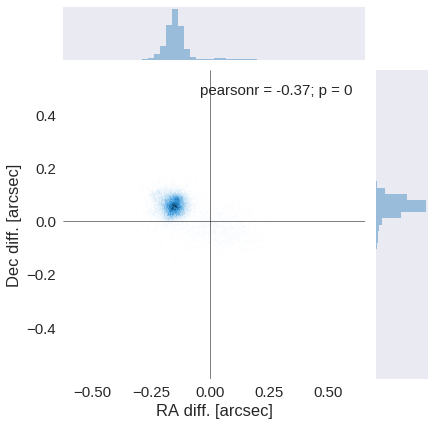

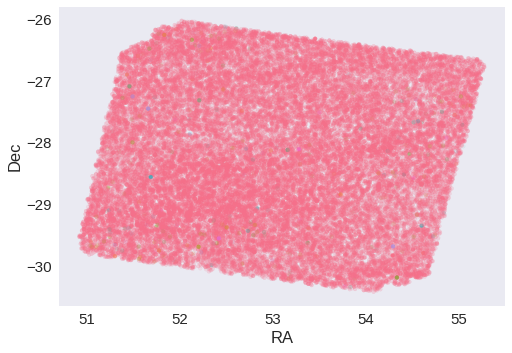

In [9]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [10]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: 0.151487537777939 arcsec
Dec correction: -0.057696934679540846 arcsec


In [11]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

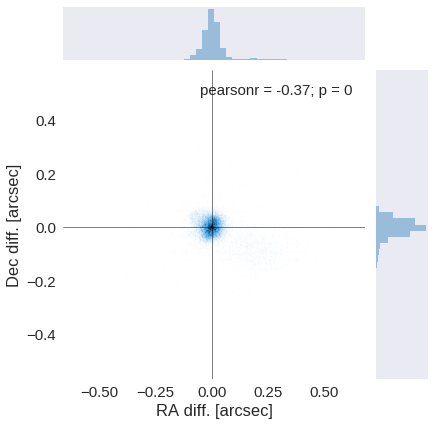

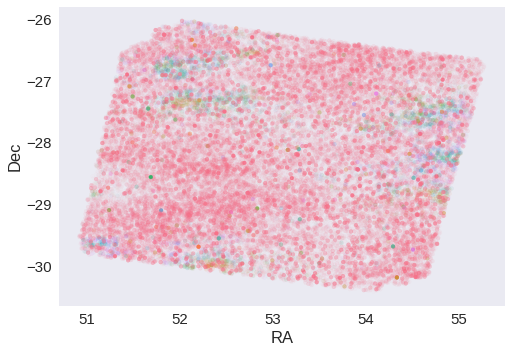

In [12]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [13]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [14]:
GAIA_FLAG_NAME = "des_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

35223 sources flagged.


## V - Flagging objects near bright stars

# VI - Saving to disk

In [15]:
catalogue.write("{}/DES.fits".format(OUT_DIR), overwrite=True)